In [156]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

In [157]:
# Load your data
path_to_application = '/home/student/Machine Learning/application_record.csv'
applicant_data = pd.read_csv(path_to_application)

In [158]:
path_to_credit = '/home/student/Machine Learning/credit_record.csv'
credit_data = pd.read_csv(path_to_credit)

Sort the DataFrame: The data is sorted by 'ID' and 'MONTHS_BALANCE', with 'MONTHS_BALANCE' sorted in descending order. This ensures that the most recent record for each ID appears first.
Select Most Recent Record: After sorting, the code groups the data by 'ID' and takes the first record for each group. This yields the most recent status per ID, as the descending sort places the latest records first.
Output: The resulting DataFrame, credit_data_agg, contains only the most recent record for each ID.

In [159]:
if 'MONTHS_BALANCE' in credit_data.columns:
    # Sort by ID and MONTHS_BALANCE to get the most recent status
    credit_data_sorted = credit_data.sort_values(by=['ID', 'MONTHS_BALANCE'], ascending=[True, False])
    
    # Now group by ID and take the first occurrence (which will be the most recent due to sorting)
    credit_data_agg = credit_data_sorted.groupby('ID').first().reset_index()
else:
    # If no 'MONTHS_BALANCE', fall back to the last status
    credit_data_agg = credit_data.groupby('ID').agg({'STATUS': 'last'}).reset_index()

Merge Datasets on 'ID':

The code merges applicant_data and credit_data DataFrames using an inner join on the column 'ID'.
Result: This creates a new DataFrame, merged_df, that includes only rows where 'ID' exists in both applicant_data and credit_data.
Remove Duplicate 'ID' Values:

After merging, the code removes any duplicate rows based on the 'ID' column. It keeps only the first occurrence of each 'ID'.
Purpose: This ensures each ID is unique in the merged DataFrame.

In [160]:
# Merge the datasets on 'ID'
merged_df = pd.merge(applicant_data, credit_data, on='ID', how='inner')
# Remove duplicate IDs (keeping the first occurrence)
merged_df = merged_df.drop_duplicates(subset='ID', keep='first')

merged_df.reset_index(drop=True, inplace=True)

# Display the first few rows of the merged DataFrame
merged_df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,C
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,C
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0,C
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-22,X


The code adds a new column, 'label', to merged_df_filtered, assigning values based on the value of 'STATUS'.
Labeling Logic:
If 'STATUS' is in ['0', '1', '2', '3', '4', '5'], label is set to 0 (indicates defaulted).
If 'STATUS' is 'C', label is set to 1 (indicates did not default).

In [161]:
# Filter the DataFrame to remove rows with STATUS 'X'
merged_df_filtered = merged_df[merged_df['STATUS'] != 'X'].copy()

# Create loan labels with only two statuses
merged_df_filtered['label'] = merged_df_filtered['STATUS'].apply(
    lambda status: 0 if status in ['0', '1', '2', '3', '4', '5'] else 1
)

# Display the first few rows of the modified DataFrame
merged_df_filtered.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS,label
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,C,1
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,C,1
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0,C,1
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0,0,0
5,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0,C,1


In [162]:
# Handle missing values in 'OCCUPATION_TYPE' with mode
occupation_mode = merged_df_filtered['OCCUPATION_TYPE'].mode()[0]
merged_df_filtered['OCCUPATION_TYPE'] = merged_df_filtered['OCCUPATION_TYPE'].fillna(occupation_mode)

Convert 'DAYS_BIRTH' to 'age':

The 'DAYS_BIRTH' column, which stores the applicant’s age in days (as a negative value), is converted to years by taking the absolute value, dividing by 365, rounding the result, and converting it to an integer.
Result: A new column, 'age', is added to merged_df_filtered, representing the applicant's age in years.<br>

Convert 'DAYS_EMPLOYED' to 'employment_duration':

The 'DAYS_EMPLOYED' column, representing employment duration in days (often as a negative value), is converted to years by taking the absolute value and dividing by 365.
Result: A new column, 'employment_duration', is added to merged_df_filtered, representing the number of years the applicant has been employed.

In [163]:
# Convert 'DAYS_BIRTH' to 'age' and 'DAYS_EMPLOYED' to 'employment_duration'
merged_df_filtered['age'] = (merged_df_filtered['DAYS_BIRTH'].abs() / 365).round().astype(int)
merged_df_filtered['employment_duration'] = merged_df_filtered['DAYS_EMPLOYED'].abs() / 365
merged_df_filtered.drop(['DAYS_BIRTH', 'DAYS_EMPLOYED'], axis=1, inplace=True)

# Renaming columns

In [164]:
# Rename columns
new_column_names = {
    'ID': 'id', 'CODE_GENDER': 'gender', 'FLAG_OWN_CAR': 'owns_car',
    'FLAG_OWN_REALTY': 'owns_property', 'CNT_CHILDREN': 'num_children',
    'AMT_INCOME_TOTAL': 'total_income', 'NAME_INCOME_TYPE': 'income_type',
    'NAME_EDUCATION_TYPE': 'education_type', 'NAME_FAMILY_STATUS': 'family_status',
    'NAME_HOUSING_TYPE': 'housing_type', 'FLAG_MOBIL': 'owns_mobile_phone',
    'OCCUPATION_TYPE': 'occupation_type', 'CNT_FAM_MEMBERS': 'number_of_family_members'
}
merged_df_filtered.rename(columns=new_column_names, inplace=True)
merged_df_filtered.head()

,id,gender,owns_car,owns_property,num_children,total_income,income_type,education_type,family_status,housing_type,owns_mobile_phone,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,occupation_type,number_of_family_members,MONTHS_BALANCE,STATUS,label,age,employment_duration
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,Laborers,2.0,0,C,1,33,12.443836
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,Laborers,2.0,0,C,1,33,12.443836
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Security staff,2.0,0,C,1,59,3.106849
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,0,0,0,52,8.358904
5,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,0,C,1,52,8.358904


In [165]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

missing_values = merged_df_filtered.isnull().sum()
# print(missing_values)

missing_columns = missing_values[missing_values > 0]
print(missing_columns)

Series([], dtype: int64)


Calculate 'total_dependents':

'total_dependents' is calculated by adding the values in 'num_children' (number of children) and 'number_of_family_members' (total family members) columns, then subtracting 1.
Explanation: The subtraction of 1 accounts for the individual themselves, 'number_of_family_members' includes the applicant along with other dependents.

In [166]:
merged_df_filtered['total_dependents'] = merged_df_filtered['num_children'] + merged_df_filtered['number_of_family_members'] - 1

'household_size' is calculated by adding the values in 'number_of_family_members' (representing the total family members) and 'num_children' (representing the number of children).

In [167]:
# Household Size
merged_df_filtered['household_size'] = merged_df_filtered['number_of_family_members'] + merged_df_filtered['num_children']

Create 'is_long_employment' Column:

The code checks if the value in 'employment_duration' is greater than 2 years.
If true, it assigns a value of 1; if false, it assigns 0. This binary result is achieved by converting the Boolean outcome to an integer with .astype(int).

In [168]:
# Employment Duration Binary
merged_df_filtered['is_long_employment'] = (merged_df_filtered['employment_duration'] > 2).astype(int)

In [169]:
# merged_df_filtered['employment_duration_months'] = merged_df_filtered['employment_duration'] * 12

In [170]:
merged_df_filtered.head()

,id,gender,owns_car,owns_property,num_children,total_income,income_type,education_type,family_status,housing_type,owns_mobile_phone,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,occupation_type,number_of_family_members,MONTHS_BALANCE,STATUS,label,age,employment_duration,total_dependents,household_size,is_long_employment
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,Laborers,2.0,0,C,1,33,12.443836,1.0,2.0,1
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,Laborers,2.0,0,C,1,33,12.443836,1.0,2.0,1
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Security staff,2.0,0,C,1,59,3.106849,1.0,2.0,1
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,0,0,0,52,8.358904,0.0,1.0,1
5,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,0,C,1,52,8.358904,0.0,1.0,1


## Visualization
This code visualizes the distribution of the target variable, 'label', in merged_df_filtered to understand the balance of different loan eligibility classes before training a model.

/tmp/ipykernel_4077/3959197402.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


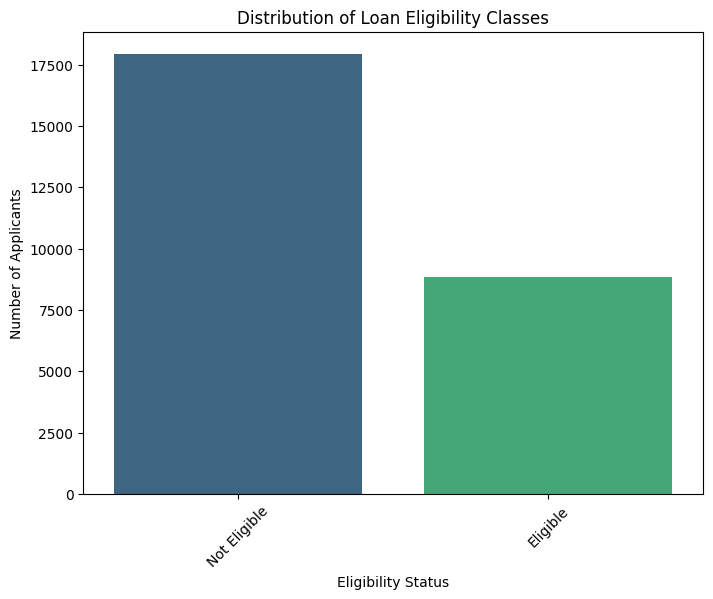

In [171]:
# Visualize the distribution of the target variable before training

# Count the occurrences of each class in the target variable
label_counts = merged_df_filtered['label'].value_counts()

# Map labels to meaningful names
label_names = {0: 'Eligible', 1: 'Not Eligible', 2: 'Other'}
label_counts.index = label_counts.index.map(label_names)

# Plotting a bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('Distribution of Loan Eligibility Classes')
plt.xlabel('Eligibility Status')
plt.ylabel('Number of Applicants')
plt.xticks(rotation=45)
plt.show()

Define Categorical Columns for Encoding:

The dataset's categorical columns are grouped by the most appropriate encoding technique for each:<br>

Categorical Ordinal Columns:<br>

categorical_ordinal_columns = ['education_type']<br>
Description: These columns have a natural order (e.g., primary, secondary).<br>
Encoding Approach: Ordinal encoding is applied, which assigns a unique integer to each category, preserving order.<br>

Categorical Binary Columns:<br>

categorical_binary_columns = ['owns_car', 'owns_property']<br>
Description: These columns represent binary features (e.g., yes/no or true/false values).<br>
Encoding Approach: Binary encoding, where each category is mapped to 0 or 1, is suitable here.<br>

Categorical Label Encode Columns:<br>

categorical_label_encode_columns = ['family_status', 'housing_type', 'occupation_type', 'STATUS']<br>
Description: These columns contain nominal categorical data without a specific order.<br>
Encoding Approach: Label encoding assigns an integer to each unique category. This encoding method works for unordered categories when using tree-based models.

In [172]:
# Encoding categorical features
categorical_ordinal_columns = ['education_type']
categorical_binary_columns = ['owns_car', 'owns_property']
categorical_label_encode_columns = ['family_status', 'housing_type', 'occupation_type', 'STATUS']

In [173]:
# Ordinal Encoding
ordinal_encoder = OrdinalEncoder()
merged_df_filtered[categorical_ordinal_columns] = ordinal_encoder.fit_transform(
    merged_df_filtered[categorical_ordinal_columns]
)

In [174]:
# Binary encoding for 'gender'
merged_df_filtered['gender'] = merged_df_filtered['gender'].map({'M': 1, 'F': 0})

In [175]:
# Label Encoding for remaining categorical columns
label_encoder = LabelEncoder()
for col in categorical_label_encode_columns:
    merged_df_filtered[col] = label_encoder.fit_transform(merged_df_filtered[col])

In [176]:
# Binary encoding for other columns
for col in categorical_binary_columns:
    
    merged_df_filtered[col] = merged_df_filtered[col].map({'Y': 1, 'N': 0})

In [177]:
merged_df_filtered.head()

,id,gender,owns_car,owns_property,num_children,total_income,income_type,education_type,family_status,housing_type,owns_mobile_phone,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,occupation_type,number_of_family_members,MONTHS_BALANCE,STATUS,label,age,employment_duration,total_dependents,household_size,is_long_employment
0,5008804,1,1,1,0,427500.0,Working,1.0,0,4,1,1,0,0,8,2.0,0,6,1,33,12.443836,1.0,2.0,1
1,5008805,1,1,1,0,427500.0,Working,1.0,0,4,1,1,0,0,8,2.0,0,6,1,33,12.443836,1.0,2.0,1
2,5008806,1,1,1,0,112500.0,Working,4.0,1,1,1,0,0,0,16,2.0,0,6,1,59,3.106849,1.0,2.0,1
3,5008808,0,0,1,0,270000.0,Commercial associate,4.0,3,1,1,0,1,1,14,1.0,0,0,0,52,8.358904,0.0,1.0,1
5,5008810,0,0,1,0,270000.0,Commercial associate,4.0,3,1,1,0,1,1,14,1.0,0,6,1,52,8.358904,0.0,1.0,1


## Column Description for training
The list features contains the names of columns that will be used as input features for the model:
'owns_car', 'owns_property': Binary indicators for car and property ownership.<br>
'num_children': Number of children the applicant has.<br>
'total_income': Applicant's total income.<br>
'education_type': Education level, likely encoded as an ordinal feature.<br>
'family_status', 'housing_type': Categorical variables representing family and housing situation.<br>
'age': Applicant’s age in years.<br>
'employment_duration': Number of years the applicant has been employed.<br>
'number_of_family_members': Total number of family members in the applicant's household.<br>
'total_dependents': Number of dependents, excluding the applicant.<br>
'is_long_employment': Binary indicator for whether employment duration exceeds two years.<br>

In [178]:
# Define features and target
features = [
    'owns_car', 'owns_property', 'num_children', 'total_income',
    'education_type', 'family_status', 'housing_type', 'age', 
    'employment_duration', 'number_of_family_members',
    'total_dependents', 'is_long_employment'
]
X = merged_df_filtered[features]
y = merged_df_filtered['label']

In [179]:
# Dropping multiple columns
columns_to_drop = ['income_type', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'owns_mobile_phone', 'MONTHS_BALANCE', 'STATUS', 'gender', 'id', 'occupation_type', 'household_size']
merged_df_filtered.drop(columns=columns_to_drop, axis=1, inplace=True)

# Display the first few rows after dropping the columns
merged_df_filtered.head()

,owns_car,owns_property,num_children,total_income,education_type,family_status,housing_type,number_of_family_members,label,age,employment_duration,total_dependents,is_long_employment
0,1,1,0,427500.0,1.0,0,4,2.0,1,33,12.443836,1.0,1
1,1,1,0,427500.0,1.0,0,4,2.0,1,33,12.443836,1.0,1
2,1,1,0,112500.0,4.0,1,1,2.0,1,59,3.106849,1.0,1
3,0,1,0,270000.0,4.0,3,1,1.0,0,52,8.358904,0.0,1
5,0,1,0,270000.0,4.0,3,1,1.0,1,52,8.358904,0.0,1


In [180]:
merged_df_filtered.head()

,owns_car,owns_property,num_children,total_income,education_type,family_status,housing_type,number_of_family_members,label,age,employment_duration,total_dependents,is_long_employment
0,1,1,0,427500.0,1.0,0,4,2.0,1,33,12.443836,1.0,1
1,1,1,0,427500.0,1.0,0,4,2.0,1,33,12.443836,1.0,1
2,1,1,0,112500.0,4.0,1,1,2.0,1,59,3.106849,1.0,1
3,0,1,0,270000.0,4.0,3,1,1.0,0,52,8.358904,0.0,1
5,0,1,0,270000.0,4.0,3,1,1.0,1,52,8.358904,0.0,1


## SMOTE 
(Synthetic Minority Over-sampling Technique): This technique is used to handle class imbalance in the dataset by creating synthetic samples for the minority class. It helps to ensure that each class has a more equal number of samples.<br>
new_label_counts: This variable counts the occurrences of each class in the resampled target variable y_resampled. This allows you to see how the class distribution has changed after applying SMOTE.
Mapping: The new_label_names dictionary is used to convert the numerical labels back into more descriptive strings for better readability. The line new_label_counts.index = new_label_counts.index.map(new_label_names) applies this mapping to the index of new_label_counts.

/tmp/ipykernel_4077/2575503159.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=new_label_counts.index, y=new_label_counts.values, palette='viridis')


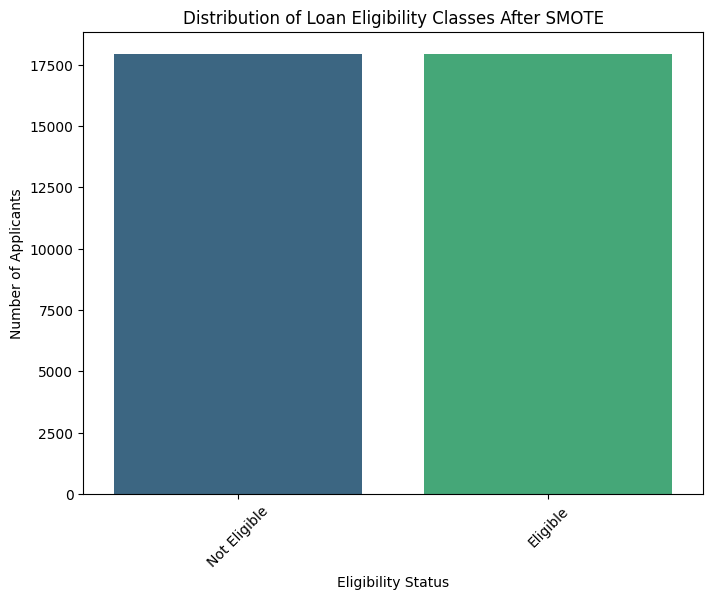

In [181]:
from imblearn.over_sampling import SMOTE

# Define features and target variable
X = merged_df_filtered[features]
y = merged_df_filtered['label']

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check the new distribution
new_label_counts = y_resampled.value_counts()
new_label_names = {0: 'Eligible', 1: 'Not Eligible', 2: 'Other'}
new_label_counts.index = new_label_counts.index.map(new_label_names)

# Plotting the new distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=new_label_counts.index, y=new_label_counts.values, palette='viridis')
plt.title('Distribution of Loan Eligibility Classes After SMOTE')
plt.xlabel('Eligibility Status')
plt.ylabel('Number of Applicants')
plt.xticks(rotation=45)
plt.show()

## Model Training

### XGBClassifier

This code implements a machine learning pipeline using XGBoost to classify data after addressing class imbalance with SMOTE. It involves resampling the dataset, splitting it into training and testing sets, training the model, and evaluating its performance through accuracy metrics and a confusion matrix visualization. The final output includes accuracy scores, a classification report, and a visual representation of the confusion matrix.

Training Accuracy: 0.76
Test Accuracy: 0.70
              precision    recall  f1-score   support

           0       0.72      0.65      0.68      3590
           1       0.68      0.74      0.71      3590

    accuracy                           0.70      7180
   macro avg       0.70      0.70      0.70      7180
weighted avg       0.70      0.70      0.70      7180

Confusion Matrix:
[[2346 1244]
 [ 920 2670]]


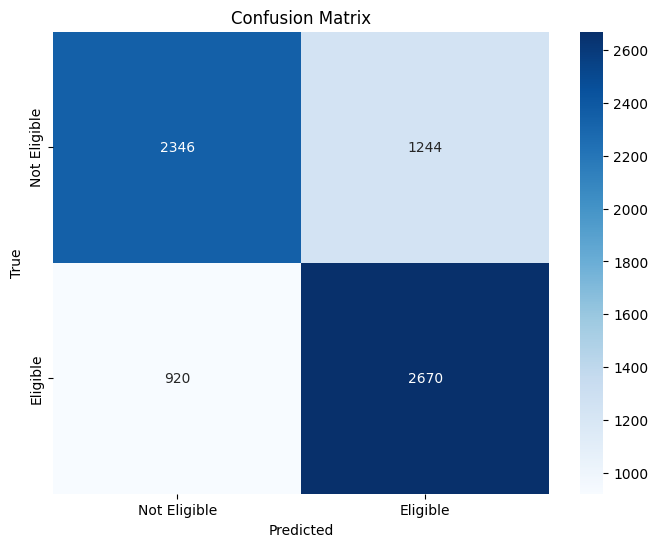

In [182]:
# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the resampled data into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Initialize the XGBoost model
model = XGBClassifier(eval_metric='logloss')

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print results
print(f'Training Accuracy: {model.score(X_train, y_train):.2f}')
print(f'Test Accuracy: {accuracy:.2f}')
print(report)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Eligible', 'Eligible'], yticklabels=['Not Eligible', 'Eligible'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [183]:
print(f'Number of features being used: {X.shape[1]}')

Number of features being used: 12


In [184]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
model = RandomForestClassifier(random_state=42)

In [185]:
merged_df_filtered.head()

,owns_car,owns_property,num_children,total_income,education_type,family_status,housing_type,number_of_family_members,label,age,employment_duration,total_dependents,is_long_employment
0,1,1,0,427500.0,1.0,0,4,2.0,1,33,12.443836,1.0,1
1,1,1,0,427500.0,1.0,0,4,2.0,1,33,12.443836,1.0,1
2,1,1,0,112500.0,4.0,1,1,2.0,1,59,3.106849,1.0,1
3,0,1,0,270000.0,4.0,3,1,1.0,0,52,8.358904,0.0,1
5,0,1,0,270000.0,4.0,3,1,1.0,1,52,8.358904,0.0,1


## RandomForestClassifier

This code implements a Random Forest classifier to predict class labels from a resampled dataset after addressing class imbalance. It splits the dataset into training and testing sets, trains the model, and makes predictions on the test data. The performance is evaluated using accuracy metrics, a classification report, and a confusion matrix, which is visualized for better interpretation of the results.

Training Accuracy: 0.86
Test Accuracy: 0.74
              precision    recall  f1-score   support

           0       0.75      0.73      0.74      3590
           1       0.73      0.75      0.74      3590

    accuracy                           0.74      7180
   macro avg       0.74      0.74      0.74      7180
weighted avg       0.74      0.74      0.74      7180

Confusion Matrix:
[[2606  984]
 [ 884 2706]]


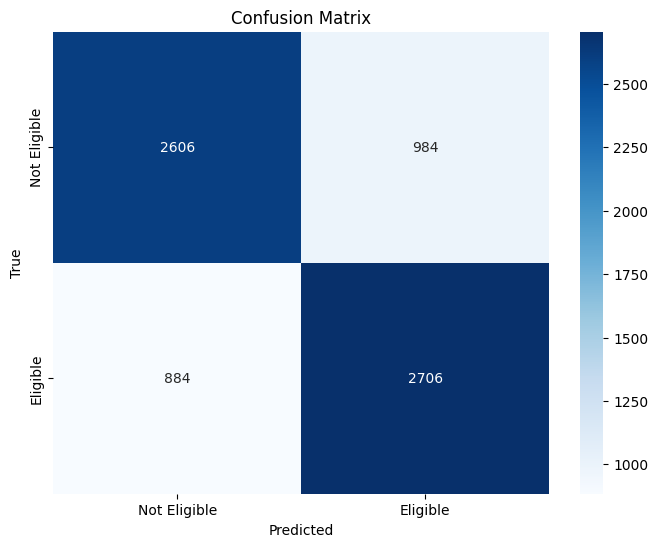

In [194]:

# Split the resampled data into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print results
print(f'Training Accuracy: {rf_model.score(X_train, y_train):.2f}')
print(f'Test Accuracy: {accuracy:.2f}')
print(report)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Eligible', 'Eligible'], yticklabels=['Not Eligible', 'Eligible'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## GradientBoostingClassifier

This code applies a Gradient Boosting classifier to a resampled dataset, effectively addressing class imbalance. It splits the data into training and testing sets, trains the model, and then makes predictions. The model's performance is assessed using accuracy scores, a classification report, and a confusion matrix, which is visualized to show the distribution of predicted versus actual class labels.

Training Accuracy: 0.63
Test Accuracy: 0.61
              precision    recall  f1-score   support

           0       0.65      0.50      0.57      3590
           1       0.59      0.72      0.65      3590

    accuracy                           0.61      7180
   macro avg       0.62      0.61      0.61      7180
weighted avg       0.62      0.61      0.61      7180

Confusion Matrix:
[[1810 1780]
 [ 990 2600]]


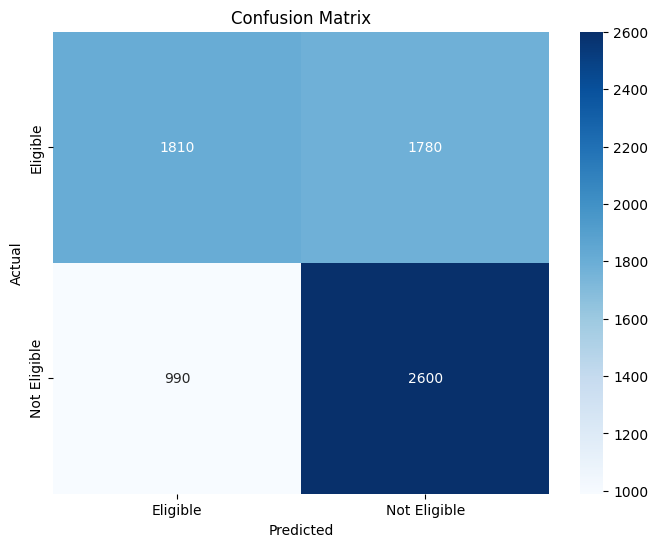

In [195]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Ensure your label mapping only includes the relevant classes
label_names = {0: 'Eligible', 1: 'Not Eligible'}

# Initialize the Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=42)

# Train the model
gb_model.fit(X_train, y_train)

# Make predictions
y_pred = gb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print results
print(f'Training Accuracy: {gb_model.score(X_train, y_train):.2f}')
print(f'Test Accuracy: {accuracy:.2f}')
print(report)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_names.values(), 
            yticklabels=label_names.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

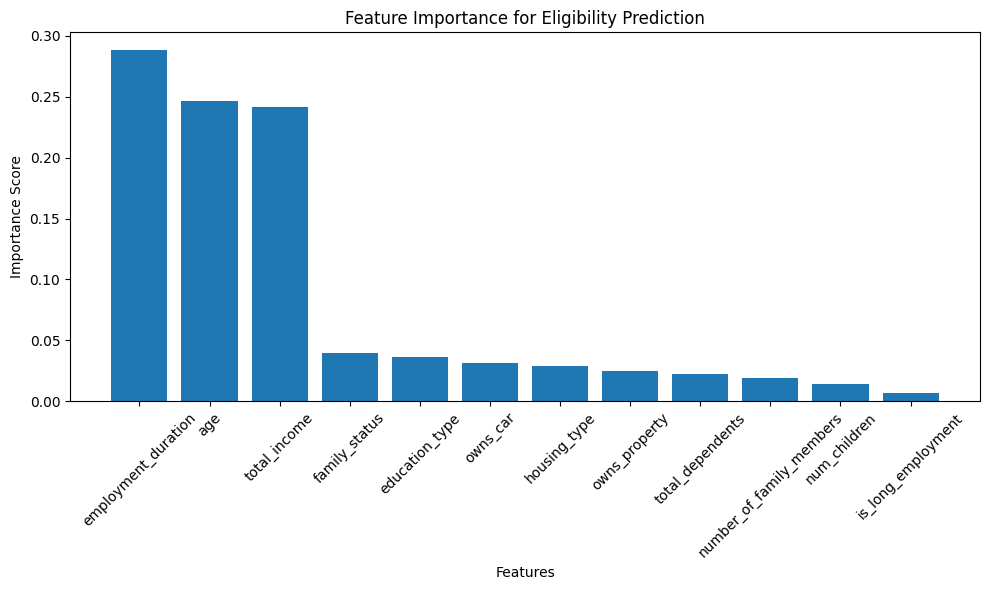

In [196]:
importances = model.feature_importances_

# Sorting features by importance
indices = np.argsort(importances)[::-1]
sorted_features = [features[i] for i in indices]
sorted_importances = importances[indices]

# Plotting feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importance for Eligibility Prediction")
plt.bar(range(len(features)), sorted_importances, align="center")
plt.xticks(range(len(features)), sorted_features, rotation=45)
plt.ylabel("Importance Score")
plt.xlabel("Features")
plt.tight_layout()
plt.show()

## LogisticRegression

This code implements a Logistic Regression model on a resampled dataset to predict eligibility. It first splits the data into training and testing sets, trains the model, and then makes predictions on the test set. The model's performance is evaluated through accuracy scores and a classification report, and the results are visualized using a confusion matrix to compare predicted versus actual eligibility statuses.

Training Accuracy: 0.56
Test Accuracy: 0.55
              precision    recall  f1-score   support

           0       0.55      0.55      0.55      3590
           1       0.55      0.56      0.56      3590

    accuracy                           0.55      7180
   macro avg       0.55      0.55      0.55      7180
weighted avg       0.55      0.55      0.55      7180

Confusion Matrix:
[[1974 1616]
 [1588 2002]]


/home/student/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


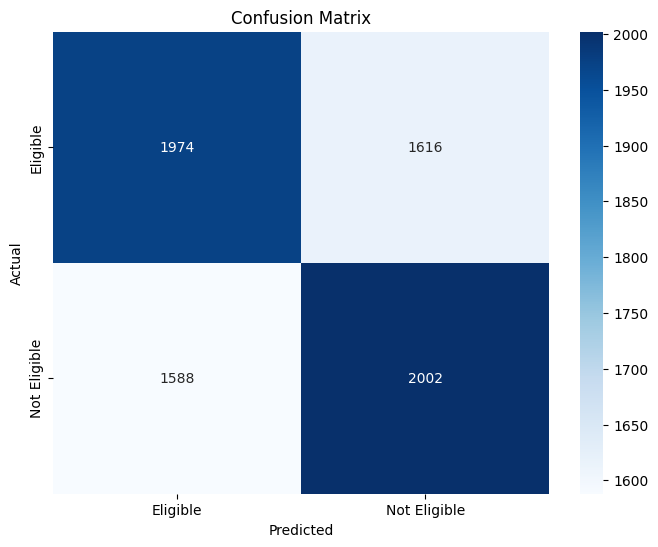

In [197]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Initialize the Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
logistic_model.fit(X_train, y_train)

# Make predictions
y_pred = logistic_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print results
print(f'Training Accuracy: {logistic_model.score(X_train, y_train):.2f}')
print(f'Test Accuracy: {accuracy:.2f}')
print(report)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Create label names for visualization
label_names = {0: 'Eligible', 1: 'Not Eligible'}

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_names.values(), 
            yticklabels=label_names.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## LinearSVC

This code snippet demonstrates the use of a Linear Support Vector Machine (SVM) model for binary classification on a resampled dataset. It begins by splitting the data into training and testing sets, followed by training the SVM model. Predictions are made on the test set, and the model's performance is assessed using accuracy metrics and a classification report. The results are further illustrated with a confusion matrix, which compares the predicted eligibility status against the actual values, providing a visual representation of the model's performance.

Training Accuracy: 0.51
Test Accuracy: 0.50
              precision    recall  f1-score   support

           0       0.50      0.41      0.45      3590
           1       0.50      0.58      0.54      3590

    accuracy                           0.50      7180
   macro avg       0.50      0.50      0.49      7180
weighted avg       0.50      0.50      0.49      7180

Confusion Matrix:
[[1474 2116]
 [1494 2096]]


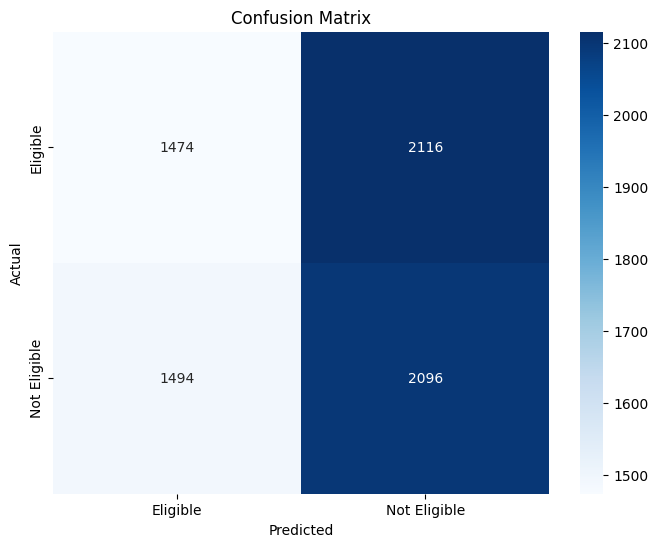

In [198]:

# Split the resampled data into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Initialize the Linear SVM model
svm_model = LinearSVC(random_state=42, max_iter=10000)

# Train the model
svm_model.fit(X_train, y_train)

# Make predictions
y_pred = svm_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print results
print(f'Training Accuracy: {svm_model.score(X_train, y_train):.2f}')
print(f'Test Accuracy: {accuracy:.2f}')
print(report)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Create label names for visualization
label_names = {0: 'Eligible', 1: 'Not Eligible'}

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_names.values(), 
            yticklabels=label_names.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()